In [1]:
import numpy as np
import deepxde as dde
from scipy.integrate import odeint
from matplotlib import pyplot as plt
import torch

N_COLLOC_POINTS = 15
device = 'cuda'
N_DIMS = 2
np.random.seed(123)

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


## Solve ODE
$$
\begin{bmatrix}
    m_1 & 0   \\
    0   & m_2
\end{bmatrix}
\begin{bmatrix} \ddot{u_x} \\ \ddot{u_y} \end{bmatrix}
+
\begin{bmatrix}
    c_1 & c_2 \\
    c_3 & c_4
\end{bmatrix}
\begin{bmatrix} \dot{u_x} \\ \dot{u_y} \end{bmatrix}
+
\begin{bmatrix}
    k_1 & k_2 \\
    k_3 & k_4
\end{bmatrix}
\begin{bmatrix} u_x \\ u_y \end{bmatrix}
=
\begin{bmatrix} f_1(t) \\ f_2(t) \end{bmatrix}
$$
where
$$ u(0) = 0 $$ and $$ \dot{u}(0) = 0 $$

In [2]:
# Define the problem
m = np.diag( np.ones( N_DIMS ) )
c = np.diag( np.ones( N_DIMS ) )
k = np.diag( np.ones( N_DIMS ) ) * 9 + np.ones( (N_DIMS, N_DIMS) )

u0 = np.zeros( N_DIMS * 2 )
# u0 = np.array( range(N_DIMS * 2) )
t  = np.linspace( 0, 4 * np.pi, 100 )

force_index = 1
def np_force(t):
    force_mask  = np.zeros( N_DIMS ).reshape(-1, 1)
    force_mask[force_index] = 1
    return np.exp(-t) * force_mask

def pt_force(t):
    return torch.cat(
        [
            torch.exp(-t).view(1, -1) if dim == force_index else (t * 0).reshape(1, -1)
            for dim in range(N_DIMS)
        ],
        axis = 0
    )

def ode(u, t):
    y    = u[ 0 : N_DIMS ].reshape(-1, 1)
    y_t  = u[ N_DIMS : ].reshape(-1, 1)
            
    y_tt = np.linalg.inv(m) @ (
        np_force(t)
        -
        c @ y_t
        -
        k @ y
    )
    return np.array( list( y_t.squeeze() ) + list(y_tt.squeeze()) )

# Solve
sol = odeint(ode, u0, t)
u   = sol[:, :N_DIMS]
u_t = sol[:, N_DIMS:]

## Select Training Data

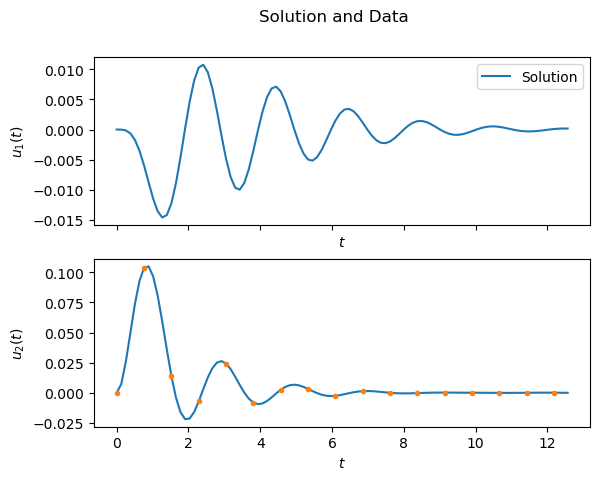

In [3]:
time_indices   = np.arange( 0, len(t), len(t) // N_COLLOC_POINTS )
sensor_indices = [1]

tdata = t[time_indices]
udata = u[time_indices]  # this data includes all dimensions, not just the sensor dimensions

# Plot
fig, ax = plt.subplots(N_DIMS, 1, sharex=True)
plt.suptitle("Solution and Data")
for dim in range(N_DIMS):
    ax[dim].plot(t, u[:, dim], label="Solution")
    if dim in sensor_indices:
        ax[dim].plot(tdata, udata[:, dim], label="Data", linestyle="None", marker=".")
    ax[dim].set_xlabel(r"$t$")
    ax[dim].set_ylabel(r"$u_{}(t)$".format(dim + 1))
    if dim == 0:
        ax[dim].legend(loc="upper right", ncol=2)

In [ ]:
# Define domain
geometry = dde.geometry.TimeDomain( t[0], t[-1] )

# Define parameters
M = torch.Tensor( m ).to( device )
C = dde.Variable( np.ones_like( c ), dtype=torch.float32 )
K = dde.Variable( np.ones_like( k ), dtype=torch.float32 )

variable_list = []
for i in range(N_DIMS):
    for j in range(N_DIMS):
        variable_list.append( C[i, j] )
        variable_list.append( K[i, j] )

# Define the ode residual
def system (t, u):
    y    = u
    y_t  = torch.zeros_like( y ).to(device)
    y_tt = torch.zeros_like( y ).to(device)
    
    for dim in range( N_DIMS ):
        y_t [:, dim] = dde.grad.jacobian( u, t, i=dim, j=0 ).squeeze()
        y_tt[:, dim] = dde.grad.hessian ( u, t, component=dim ).squeeze()
            
    residual = (
        torch.mm( M, y_tt.permute((1, 0)) )
        +
        torch.mm( torch.abs(C), y_t.permute((1, 0)) )
        +
        torch.mm( torch.abs(K), y.permute((1, 0)) )
        -
        pt_force(t)
    ).permute((1, 0))
    return residual

bcs = [
    dde.icbc.boundary_conditions.PointSetBC( tdata.reshape(-1, 1), udata[:, dim].reshape(-1, 1), component=dim )
    for dim in sensor_indices
]

data = dde.data.PDE(
    geometry     = geometry,
    pde          = system,
    bcs          = bcs,
    num_domain   = 5000,
    num_boundary = 2,
    num_test     = 5
)

net = dde.nn.FNN(
    layer_sizes        = [1] + 20*[32] + [N_DIMS],
    activation         = "tanh",
    kernel_initializer = "Glorot uniform"
)

model = dde.Model(data, net)
model.compile("adam", lr=1e-4, external_trainable_variables=[C, K])

variable = dde.callbacks.VariableValue(
  variable_list, period=1000, filename="variables.dat"
)

checkpoint = dde.callbacks.ModelCheckpoint("checkpoints/model", period=2_000)

epoch = -1
def plot():
    global epoch
    epoch += 1
    if checkpoint.epochs_since_last_save + 1 < checkpoint.period: return
    upred = model.predict(t.reshape(-1, 1))
    fig, ax = plt.subplots(N_DIMS, 1, sharex=True)
    plt.suptitle(f"Epoch {epoch}")
    for dim in range(N_DIMS):
        ax[dim].plot(t, u[:, dim], label="Solution", color='blue')
        if dim in sensor_indices:
            ax[dim].plot(tdata, udata[:, dim], label="Data", linestyle="None", marker=".", color='orange')
        ax[dim].plot(t, upred[:, dim], label="Prediction", color='green')
        ax[dim].set_xlabel(r"$t$")
        ax[dim].set_ylabel(r"$u_{}(t)$".format(dim + 1))
        if dim == 0:
            ax[dim].legend(loc="upper right", ncol=2)
    plt.savefig(f"plots/epoch_{epoch}_prediction.png")
    plt.close(plt.gcf())

checkpoint.on_epoch_begin = plot

losshistory, train_state = model.train(iterations=2_000_000, callbacks=[variable, checkpoint])

534000    [6.71e-06, 9.60e-07]    [2.51e-06, 9.60e-07]    []  
535000    [2.15e-07, 9.31e-07]    [1.70e-07, 9.31e-07]    []  
536000    [2.62e-07, 8.98e-07]    [1.37e-07, 8.98e-07]    []  
537000    [6.35e-07, 8.66e-07]    [4.69e-07, 8.65e-07]    []  
538000    [4.77e-06, 9.84e-07]    [4.69e-06, 9.84e-07]    []  
539000    [2.06e-07, 8.58e-07]    [1.97e-07, 8.58e-07]    []  
540000    [1.94e-07, 8.32e-07]    [1.85e-07, 8.32e-07]    []  
541000    [1.86e-07, 8.15e-07]    [1.73e-07, 8.15e-07]    []  
542000    [1.88e-07, 7.95e-07]    [1.58e-07, 7.95e-07]    []  
543000    [6.19e-07, 7.63e-07]    [6.48e-07, 7.63e-07]    []  
544000    [3.54e-07, 7.94e-07]    [2.68e-07, 7.94e-07]    []  
545000    [2.81e-07, 7.39e-07]    [2.49e-07, 7.39e-07]    []  
546000    [1.53e-06, 6.78e-07]    [3.94e-07, 6.78e-07]    []  
547000    [5.84e-07, 7.37e-07]    [4.55e-07, 7.37e-07]    []  
548000    [2.36e-06, 7.79e-07]    [2.24e-06, 7.79e-07]    []  
549000    [5.86e-07, 7.16e-07]    [4.34e-07, 7.16e-07] 

In [ ]:
upred = model.predict(t.reshape(-1, 1))

fig, ax = plt.subplots(N_DIMS, 1, sharex=True)
plt.suptitle("Prediction, Solution, and Data")
for dim in range(N_DIMS):
    ax[dim].plot(t, u[:, dim], label="Solution")
    if dim in sensor_indices:
        ax[dim].plot(tdata, udata[:, dim], label="Data", linestyle="None", marker=".")
    ax[dim].plot(t, upred[:, dim], label="Prediction")
    ax[dim].set_xlabel(r"$t$")
    ax[dim].set_ylabel(r"$u_{}(t)$".format(dim + 1))
    if dim == 0:
        ax[dim].legend(loc="upper right", ncol=2)

plt.savefig("20_layers_diagonalC_ydata_only.png")

In [ ]:
model.save("20_layers_diagonalC_ydata_only")

In [ ]:
print(C.detach())
print(K.detach())

In [ ]:
from PIL import Image
import glob

frames = []
images = glob.glob("plots/epoch_*_prediction.png")

def sort_by_number(filename):
    number = int(filename.split('_')[1].split('_')[0])  # Extract the number from the file name
    return number

sorted_images = sorted(images, key=sort_by_number)

for image in sorted_images:
    frames.append(Image.open(image))

frames[0].save('training.gif', format='GIF',
               append_images=frames[1:],
               save_all=True,
               duration=45,
               loop=0)